# AlexNet

### Imports

In [6]:
import os
import torch
import numpy as np
import torchvision
from vgg16_model import VGG16
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../helper_functions/')

from train import train_model
from eval import set_seed, compute_confusion_matrix
from plot import plot_training_loss, plot_accuracy, plot_confusion_matrix
from dataset_loader import get_dataloaders_cifar10, unNormalize

### Initialize Setting

In [7]:
RANDOM_SEED = 123
BATCH_SIZE  = 256
NUM_EPOCHS  = 50

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', DEVICE)
set_seed(RANDOM_SEED)

Device:  cuda:0


### Applying Transforms to the Dataset

In [8]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor()
])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=test_transforms,
    test_transforms=test_transforms,
    num_workers=2
)

train_mean, train_std = [], []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()

    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))

    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = np.mean(train_mean, axis=0)
train_std = np.mean(train_std, axis=0)

print('Mean: ', train_mean)
print('Std: ', train_std)

Files already downloaded and verified
Mean:  [0.4894929  0.4773143  0.44135574]
Std:  [0.23783134 0.23433842 0.25187373]


In [9]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(train_mean, train_std)
])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2
)

Files already downloaded and verified


### Training

In [10]:
model = VGG16(num_classes=10)

model = model.to(DEVICE)
print("Device: ", DEVICE)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

torch.cuda.empty_cache()
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100,
    scheduler=scheduler,
    scheduler_on='valid_acc')

Device:  cuda:0
Epoch: 001/050 | Batch 0000/0175 | Loss: 6.3206
Epoch: 001/050 | Batch 0100/0175 | Loss: 2.0364
Epoch: 001/050 | Train: 30.27% | Validation: 30.84%
Time elapsed: 1.63 min
Epoch: 002/050 | Batch 0000/0175 | Loss: 1.8350
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.5979
Epoch: 002/050 | Train: 40.42% | Validation: 40.95%
Time elapsed: 3.21 min
Epoch: 003/050 | Batch 0000/0175 | Loss: 1.6386
Epoch: 003/050 | Batch 0100/0175 | Loss: 1.4802
Epoch: 003/050 | Train: 51.58% | Validation: 51.44%
Time elapsed: 4.80 min
Epoch: 004/050 | Batch 0000/0175 | Loss: 1.2028
Epoch: 004/050 | Batch 0100/0175 | Loss: 1.1462
Epoch: 004/050 | Train: 62.33% | Validation: 62.71%
Time elapsed: 6.38 min
Epoch: 005/050 | Batch 0000/0175 | Loss: 1.1131
Epoch: 005/050 | Batch 0100/0175 | Loss: 1.1255
Epoch: 005/050 | Train: 66.59% | Validation: 65.85%
Time elapsed: 7.97 min
Epoch: 006/050 | Batch 0000/0175 | Loss: 0.8589
Epoch: 006/050 | Batch 0100/0175 | Loss: 0.9004
Epoch: 006/050 | Train: 71.98% | 

TypeError: plot_training_loss() got an unexpected keyword argument 'num_epochs'

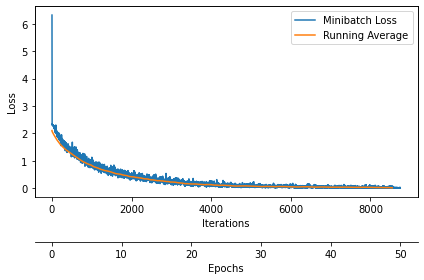

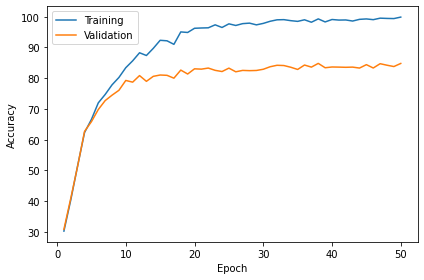

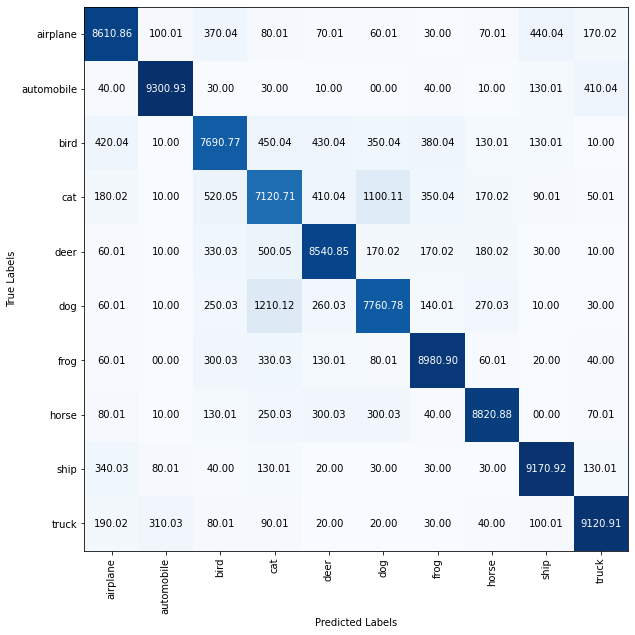

In [14]:
plot_training_loss(mini_batch_loss_list=minibatch_loss_list,
                   num_epoch=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   result_dir=None,
                   averaging_iteration=200)

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.show()

model.cpu()

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, figsize=(10, 10), show_absolute=True, class_names=class_dict.values())
plt.show()

In [15]:
os.makedirs('../save_model', exist_ok=True)
torch.save(model.state_dict(), '../save_model/VggNet.pt')